In [376]:
import pandas as pd
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [377]:
# Set the base directory correctly to your dataset location
base_dir = 'data'
file_pattern = '**/*.sign'
files = glob.glob(os.path.join(base_dir, file_pattern), recursive=True)

# Check if files are being detected
print(f"Detected {len(files)} files.")

Sub = [
    "adam1", "adam2", "andrew1", "andrew2", "andrew3",
    "john1", "john2", "john3", "john4", "john5",
    "stephen1", "stephen2", "stephen3", "stephen4",
    "waleed1", "waleed2", "waleed3", "waleed4"
]

FEATURES = ["x", "y", "z", "roll", "thumb", "fore", "index", "ring"]

def read_data(path):
    data = {samples: [] for samples in Sub}
    classes = {c: [] for c in Sub}

    for file in path:
        sub_name = os.path.basename(os.path.dirname(file))
        sign = os.path.splitext(os.path.basename(file))[0]

        df = pd.read_csv(file, header=None, delimiter=',')
        df = df.iloc[:, :-5] #features to drop
        df = df.drop(df.columns[[4, 5]], axis=1)

        clean_data = df.to_numpy()
        updated_data = {f"{label}": clean_data[:, i] for i, label in enumerate(FEATURES)}
        data[sub_name].append(updated_data)
        classes[sub_name].append(sign)

    return data, classes

data, label = read_data(files)


Detected 6756 files.


In [378]:
t1 = 0
for i in data["adam1"]:
    for idx , j in enumerate(label["adam1"]): 
        if j == 'forget0':
            t1 = (idx)
            break

wild = data["adam1"][176]["x"]
forget = data["adam1"][40]["x"]
sad = data["adam1"][128]["x"]


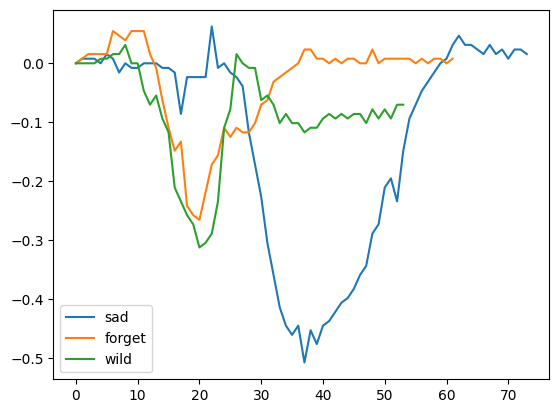

In [379]:
plt.plot(sad , label="sad")
plt.plot(forget, label= "forget")
plt.plot(wild, label="wild")
plt.legend()

In [380]:
def process_data_sample(data_sample):
	data_list =[]
	for i in data_sample.keys():
		data_list.append(data_sample[i])
	return np.array(data_list)

In [381]:
# fixing lables format
for i in data.keys():
	for j in range(len(label[i])):
		label[i][j] = label[i][j][:-1]

In [382]:
final_data = []
final_labels = []
for i in data.keys():
	for j in range(len(data[i])):
		final_data.append(process_data_sample(data[i][j]))
		final_labels.append(label[i][j])

In [383]:
def resample_row( original_array, target_length):

        data_array = original_array[:]

        # time points
        original_length = original_array.shape[0]
        time_points_original = np.linspace(0, 1, original_length)

        # linear interpolation
        time_points_resampled = np.linspace(0, 1, target_length)
        resampled_array = np.interp(time_points_resampled, time_points_original, data_array)
        return resampled_array

def resample_array( array, target_length):
        
        resample_array = []
        for i in array:
            j = resample_row((i).astype(float), target_length)
            resample_array.append(j)
        return np.array(resample_array)

In [384]:
mc_data = []
mc_labels = []
for i in range(len(final_labels)):
	if(final_data[i].shape[1] > 33):
		mc_data.append(resample_array(final_data[i] , 34))
		mc_labels.append(final_labels[i])

In [385]:

np_mc_data = np.array(mc_data)

In [386]:

wild_data = []
forget_data = []
sad_data = []

# Iterate through the labels and data arrays
for label, data_array in zip(mc_labels, mc_data):
    # Check if the label matches 'wild'
    if label == 'forget':
        # Append the corresponding data to the wild_data list
        forget_data.append(data_array)
    elif label =='wild':
        wild_data.append(data_array)
    elif label == 'sad':
        sad_data.append(data_array)

# Convert the list of wild data arrays to a numpy array
wild_data = np.array(wild_data)
sad_data = np.array(sad_data)
forget_data = np.array(forget_data)



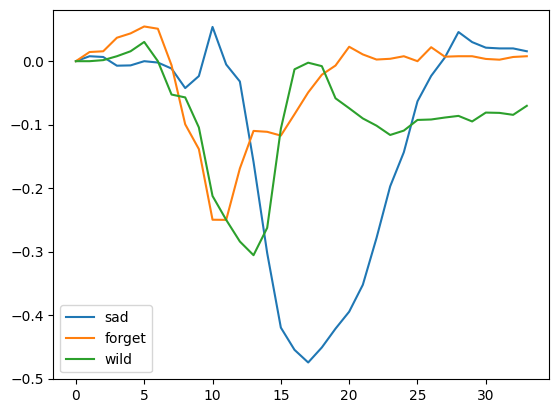

In [387]:
plt.plot(sad_data[0][0], label='sad')
plt.plot(forget_data[0][0], label='forget')
plt.plot(wild_data[0][0], label='wild')
plt.legend()



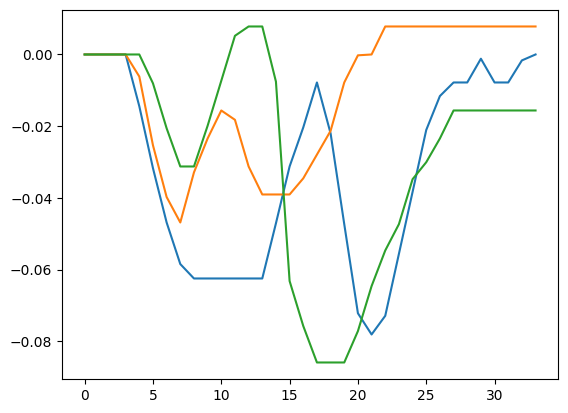

In [388]:
plt.plot(sad_data[0][2], label='sad')
plt.plot(forget_data[0][2], label='forget')
plt.plot(wild_data[0][2], label='wild')

In [389]:
np_mc_data.shape

(6732, 8, 34)

In [390]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(mc_labels)
encoded_labels = encoded_labels.reshape(-1, 1)


In [391]:
N_samples, N_steps, N_features = np_mc_data.shape

d2_data = np_mc_data.reshape((N_samples, N_steps * N_features))

X = d2_data
y = encoded_labels

# Splitting train and test data
X_train, X_v, Y_train, Y_v = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test,Y_val, Y_test= train_test_split(X_v, Y_v, test_size=0.5, random_state=42, shuffle=True)



In [392]:
d2_data.shape , encoded_labels.shape

((6732, 272), (6732, 1))

In [393]:
print("X_train is a ", type(X_train), " of length", len(X_train))
print("For sample 0: ", type(X_train[0]), " with shape ", X_train[0].shape)

print("Y_train is a ", type(Y_train), " of length", len(Y_train))
print("For sample 0: ", type(Y_train[0]), " with shape ", Y_train[0].shape)

X_train is a  <class 'numpy.ndarray'>  of length 5385
For sample 0:  <class 'numpy.ndarray'>  with shape  (272,)
Y_train is a  <class 'numpy.ndarray'>  of length 5385
For sample 0:  <class 'numpy.ndarray'>  with shape  (1,)


In [394]:
#needs to be loaded twice

from pyrcn.echo_state_network import ESNClassifier
from pyrcn.base.blocks import InputToNode, NodeToNode
from sklearn.linear_model import Ridge

In [400]:

input_layer = InputToNode(hidden_layer_size=600, input_scaling=0.9, bias_scaling=0.4)
hidden_layer = NodeToNode(hidden_layer_size=600, spectral_radius=0.01, leakage=1)

esn = ESNClassifier(input_to_node=input_layer,
                   node_to_node=hidden_layer,
                   regressor=Ridge(alpha=1e-8), random_state=42)

Y_pred = esn.fit(X=X_train, y=Y_train).predict(X=X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print(f'Accuracy: {accuracy * 100:.2f}')


Accuracy: 42.58


In [396]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

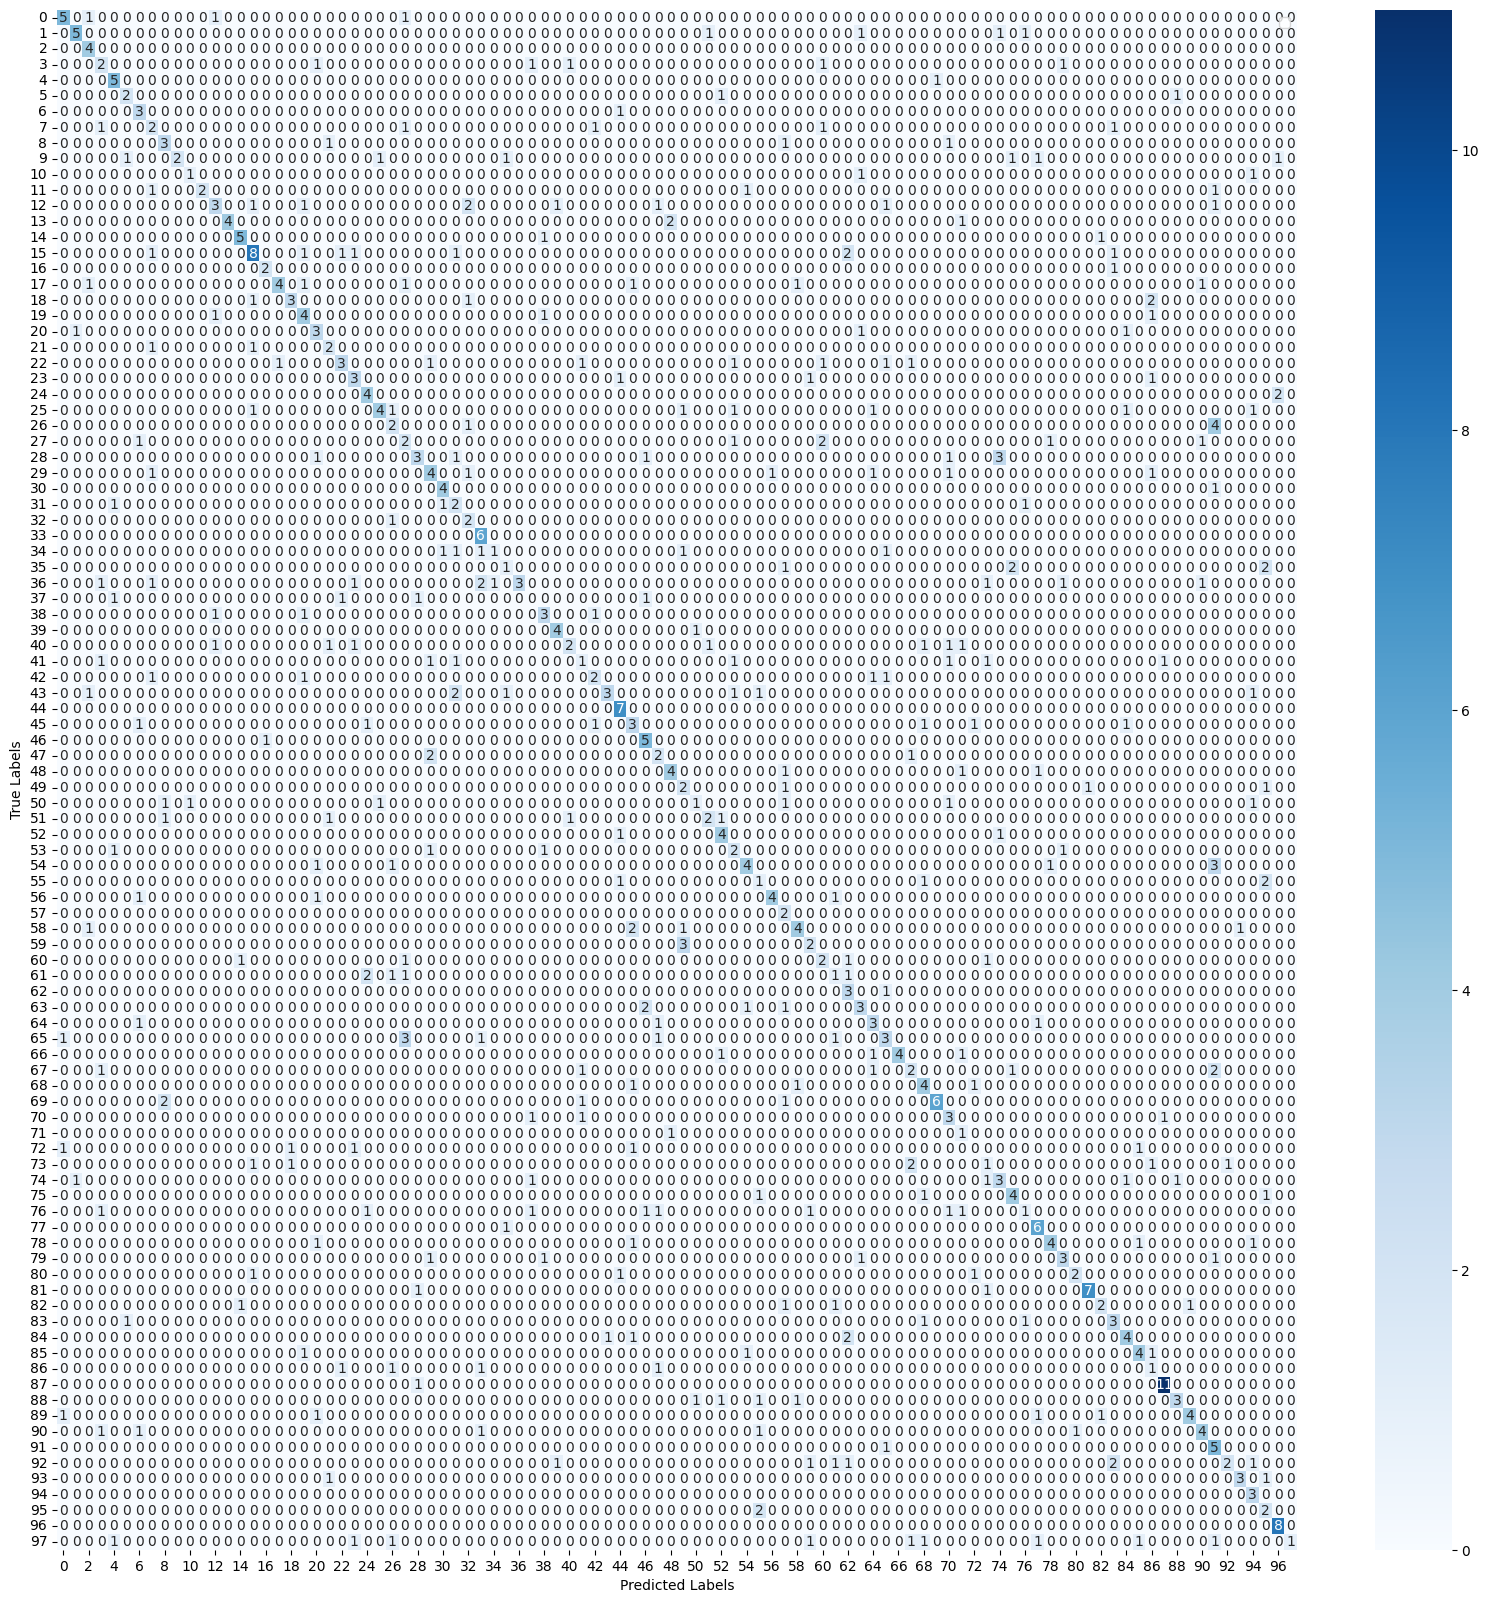

In [397]:
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.legend()
plt.show()

In [398]:
def plot_results(y_pred, y_test, sample=100):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(y_test[:sample], linestyle="--", lw=2, label="True value")

    plt.legend()
    plt.show()

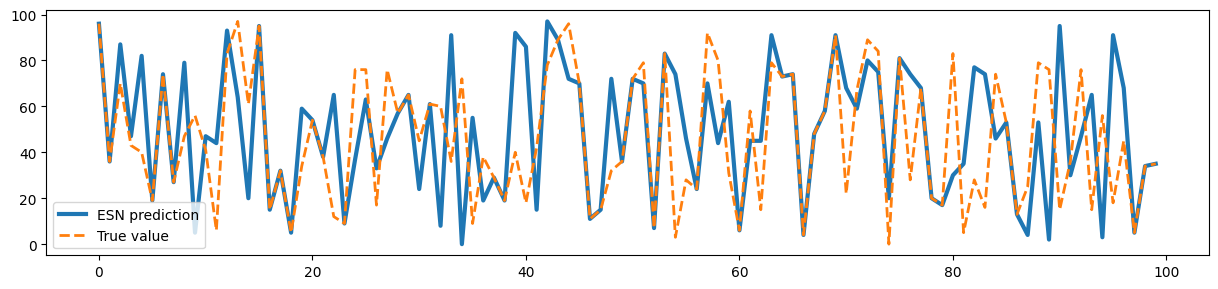

In [401]:
plot_results(Y_pred[100:], Y_test[100:])